# MIE1624 Introduction to Data Science and Analytics

## Assignment#2 Natural Language Processing Analysis

## Yixiao Hong - 1001311145

## 0.Background:
Sentiment Analysis is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”. Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals and organizations to detect trends in public opinion by analyzing social media content. Keeping abreast of socio-political developments is especially important during periods of policy shifts such as election years, when both electoral candidates and companies can benefit from sentiment analysis by making appropriate changes to their campaigning and business strategies respectively. 

### 0.1 The purpose of this assignment:
The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted in 2019 Canadian elections - and answer the research question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” The goal is to essentially use sentiment analysis on Twitter data to get insight into the 2019 Canadian elections. Central to sentiment analysis are techniques first developed in text mining. Some of those techniques require a large collection of classified text data often divided into two types of data, a training data set and a testing data set. The training data set is further divided into data used solely for the purpose of building the model and data used for validating the model. The process of building a model is iterative, with the model being successively refined until an acceptable performance is achieved. The model is then used on the testing data in order to calculate its performance characteristics.

### 0.2 Import libraries needed for the project:

In [0]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import time
rands = 5

## 1.Data cleaning (20 marks):
The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below.


1. All html tags and attributes (i.e., /<[^>]+>/) are removed
2. Html character codes (i.e., &...;) are replaced with an ASCII equivalent
3. All URLs are removed
4. All characters in the text are in lowercase.
5. All stop words are removed. Be clear in what you consider as a stop word.
6. If a tweet is empty after pre-processing, it should be preserved as such.



### 1.1 Load the Datasets and Preprocess


In [0]:
#Read the Sentiment DataSet
df_sentiment = pd.read_csv("https://raw.githubusercontent.com/YixiaoHong/NLP/master/Sentiment.csv", low_memory = False)

#Read the Sentiment DataSet
df_elections = pd.read_csv("https://raw.githubusercontent.com/YixiaoHong/NLP/master/Canadian_elections_2019.csv", low_memory = False)

In [0]:
#Have a brief view of the datasets
df_sentiment.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [0]:
df_sentiment.shape

(133811, 2)

In [0]:
df_elections.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [0]:
df_elections.shape

(2133, 3)

#### 1.1.1 Drop Rows with NaN in column "text" or "sentiment"

In [0]:
df_sentiment.isnull().sum()

sentiment     0
text         14
dtype: int64

In [0]:
df_elections.isnull().sum()

sentiment             0
negative_reason    1126
text                  0
dtype: int64

There are 14 rows with NaN value in Text in Sentiment Dataset, Drop them.
There is no NaN value in "text"/"sentiment" in elections dataset

In [0]:
df_elections.dropna(subset=["text"],inplace=True)
df_sentiment.dropna(subset=["text"],inplace=True)

In [0]:
print(df_elections.shape)
print(df_sentiment.shape)

(2133, 3)
(133797, 2)


#### 1.1.2 Label Sentiment into Integer Labels


In [0]:
df_sentiment['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [0]:
df_elections['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

**Notice that the goal is to predict the 2019 Canadian elections data set, and it has only the targets of Negative and Positive, thus the training data for the model will be choosen to be only the Negative and Positive entries in the Sentiment dataset**

In [0]:
df_sentiment = df_sentiment.loc[df_sentiment['sentiment'] != 'Neutral']

In [0]:
#label Positive as 1 , Negative as 0
df_sentiment['target'] = df_sentiment['sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)
df_elections['target'] = df_elections['sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [0]:
df_sentiment.head()

,sentiment,text,target
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,1
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",0
2,Positive,I'm listening The Beatles now. They're great,1
3,Positive,@ddlovato could i please get a shout out or an...,1
4,Positive,@salspizza just spotted ur message there Tony ...,1


In [0]:
df_elections.head()

,sentiment,negative_reason,text,target
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",1
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",1
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0


### 1.2 Perform Data Set Cleaning

In this section, I'm using the following techniques to replace the iralevent characters in the text:
I defined a function which takes the raw text and will return the text after cleaning

1.   Using Regex (Regular Expression) to search and replace the special characters in the text
2.   Load the given txt file "stop_words.txt" and remove words in the tweets which appears in the list of stop_words



#### 1.2.1 Prepare the function for cleaninig

In [0]:
#Load the stop word file to a list

#!pip install urllib
import urllib
stop_words_list = []
stop_words = urllib.request.urlopen('https://raw.githubusercontent.com/YixiaoHong/NLP/master/stop_words.txt')
for line in stop_words:
  # stop_words_list.append(line[2:-3])
  stop_words_list.append(line.decode("utf-8")[:-1])  #Decode Byte to String and drop the last \n

I loaded the given stop words list into a list and it will be used to drop the less important words in the twwets

> "Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead."
https://kavita-ganesan.com/what-are-stop-words/#.Xne_J-hKhPY




In [0]:
import re
import unicodedata
import string

def text_cleanning_sentiment(text):
  # All characters in the text are in lowercase.
  text = text.lower()

  # All URLs are removed (example: https://t.co/DxnjJUXeLe)
  regex_pattern = re.compile('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
  text = re.sub(regex_pattern, ' ', text)

  #All html tags and attributes (i.e., /<[^>]+>/) are removed;  # Html character codes (i.e., &...;) are replaced with an ASCII equivalent
  regex_pattern = re.compile('[^A-Za-z0-9\s]') #use a negative match to replace all special characters to space
  text = re.sub(regex_pattern, ' ', text)

  #Remove the "RT" reply HashTag
  regex_pattern = re.compile('rt\s')
  text = re.sub(regex_pattern, ' ', text)

  #Remove emoji codes start with "x" followed by 2-3 digits
  regex_pattern = re.compile('\sx\w{2,3}')
  text = re.sub(regex_pattern, ' ', text)

  #Remove duplicate spaces and strp front and end spaces
  text = re.sub(' +',' ',text)
  text = text.strip()

  #make text to a list of words
  text_list = text.split(' ')
  
  # All stop words are removed. Be clear in what you consider as a stop word.
  text_drop_stop_words_list = [x for x in text_list if x not in stop_words_list]

  #Reconstruct the list to string by adding space in between
  text = " ".join(text_drop_stop_words_list)

  # If a tweet is empty after pre-processing, it should be preserved as such.
  return text


def text_cleanning_electiont(text):
  #Remove the r" at begining and " at the end
  text = text[2:-1]

  # All characters in the text are in lowercase.
  text = text.lower()

  # All URLs are removed (example: https://t.co/DxnjJUXeLe)
  regex_pattern = re.compile('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
  text = re.sub(regex_pattern, ' ', text)

  #All html tags and attributes (i.e., /<[^>]+>/) are removed;  # Html character codes (i.e., &...;) are replaced with an ASCII equivalent
  regex_pattern = re.compile('[^A-Za-z0-9\s]') #use a negative match to replace all special characters to space
  text = re.sub(regex_pattern, ' ', text)

  #Remove the "RT" reply HashTag
  regex_pattern = re.compile('rt\s')
  text = re.sub(regex_pattern, ' ', text)
  
  #Remove emoji codes start with "x" followed by 2-3 digits
  regex_pattern = re.compile('\sx\w{2,3}')
  text = re.sub(regex_pattern, ' ', text)

  #Remove duplicate spaces and strp front and end spaces
  text = re.sub(' +',' ',text)
  text = text.strip()

  #make text to a list of words
  text_list = text.split(' ')
  
  # All stop words are removed. Be clear in what you consider as a stop word.
  text_drop_stop_words_list = [x for x in text_list if x not in stop_words_list]

  #Reconstruct the list to string by adding space in between
  text = " ".join(text_drop_stop_words_list)

  # If a tweet is empty after pre-processing, it should be preserved as such.
  return text


#### 1.2.2 Apply the cleaning function to the data set of column "text" and put the cleaned text in column "cleaned_text"

In [0]:
df_sentiment['cleaned_text'] = df_sentiment['text'].apply(text_cleanning_sentiment)
df_elections['cleaned_text'] = df_elections['text'].apply(text_cleanning_electiont)

In [0]:
df_sentiment.head()

,sentiment,text,target,cleaned_text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,1,diplomtc immnty realdonaldtrump amp poll numbe...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",0,chiefy74 damn jealous wanna watch fight love ufc
2,Positive,I'm listening The Beatles now. They're great,1,listening beatles great
3,Positive,@ddlovato could i please get a shout out or an...,1,ddlovato shout huge fan wait cd
4,Positive,@salspizza just spotted ur message there Tony ...,1,salspizza spotted ur message tony replied


In [0]:
df_elections.head()

,sentiment,negative_reason,text,target,cleaned_text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0,rosiebarton suggestion agree canadian women tr...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",1,allwomanspacewalk real space station etobicoke...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0,brantford going cost 94 billion 4 years justin...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",1,canada canadaelection2019 canadavotes elxn43 n...
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0,canada taxpayers sick amp tired hard earned do...


#### 1.2.3 Apply Lemmatization
Apply lemmatization to remove inflections of words

In [0]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wnLemm = WordNetLemmatizer()
df_sentiment['cleaned_text'] = df_sentiment['cleaned_text'].apply(lambda x: wnLemm.lemmatize(x,'v'))
df_elections['cleaned_text'] = df_elections['cleaned_text'].apply(lambda x: wnLemm.lemmatize(x,'v'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## 2.Exploratory analysis (15 marks):


*   Design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties. What can you say about the distribution of the political affiliations of the tweets?
*   Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that visualizes some aspect of the generic tweets from Sentiment.csv file and another figure for the 2019 Canadian election tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.



### 2.1 Summarize most frequently shown words in " 2019 Canadian election tweets"

In this section, I'm trying to summarize the frequency of words appeared in the "2019 Canadian election tweets" and manually pick some words which is related to some party in the list "liberal_keys", "conservative_keys", "ndp_keys"

In [0]:
from collections import Counter
list_tweets = [t.split() for t in df_elections['cleaned_text']]

# Concatenate
tokenized_tweets = []
for t in list_tweets:
    tokenized_tweets = tokenized_tweets + t
    
# Get Word Frequency
df_keywords = pd.DataFrame(Counter(tokenized_tweets).most_common(),columns=['key_word', 'count'])

In [0]:
# Display the most frequently used words
df_keywords.head(50)

,key_word,count
0,elxn43,2120
1,cdnpoli,1158
2,vote,273
3,cpc,257
4,canada,249
5,party,234
6,amp,229
7,will,217
8,scheer,213
9,election,211


### 2.2 Determine the keywords related to specific political party
By observing the above list, I picked some of the keywords which can classify the tweets to be related to specific political party

In [0]:
#Define the keywords related to each political party
liberal_keys = ['trudeau', 'chooseforward','liberal','justintrudeau','kinsella','trudeaumustgo','kinsellagate','liberals','justin','lpc','voteliberal','warren']
conservative_keys = ['cpc','scheer','andrewscheer','hq','conservative','conservatives','andrew','scheerlies',"cpchq",'votecarol','harper','voteconservative']
ndp_keys = ['ndp','thejagmeetsingh','uprisingh','jagmeet','ndp2019','singh','votendp']

A tweet contains none of the above keywords is classified as "None", the following function takes a string of tweet and determines which politicla party this tweets is realted to, the function loops through each words and if one of the party's keywords appears, the list will append a tag from that party, in the end, the most shown tags will be treated as the tweet's most related party (if a tie, take the first appeared party)

In [0]:
def which_party(text):
  tag_list = []
  text_list = text.split(' ')
  for word in text_list:
    if word in liberal_keys:
      tag_list.append("liberal")
    elif word in conservative_keys:
      tag_list.append("conservative")
    elif word in ndp_keys:
      tag_list.append("ndp")
  
  if len(tag_list)==0:
    return 'None'
  elif len(tag_list)==1:
    return tag_list[0]
  else:
    count_dict = dict()
    for tag in tag_list:
      if tag == "liberal":
        if "liberal" not in count_dict:
          count_dict["liberal"] = 1
        else:
          count_dict["liberal"] +=1
      elif tag == "conservative":
        if "conservative" not in count_dict:
          count_dict["conservative"] = 1
        else:
          count_dict["conservative"] +=1
      elif tag == "ndp":
        if "ndp" not in count_dict:
          count_dict["ndp"] = 1
        else:
          count_dict["ndp"] +=1
    
    final_tag = "None"
    most_count = 0
    for key in count_dict:
      if final_tag == "":
        final_tag = key
        most_count = count_dict[key]
      else:
        if count_dict[key] > most_count:
          final_tag = key
          most_count = count_dict[key]
    return final_tag

In [0]:
df_elections['party'] = df_elections['cleaned_text'].apply(lambda x: which_party(x))
df_elections[['target','cleaned_text','party']].head()

,target,cleaned_text,party
0,0,rosiebarton suggestion agree canadian women tr...,conservative
1,1,allwomanspacewalk real space station etobicoke...,None
2,0,brantford going cost 94 billion 4 years justin...,liberal
3,1,canada canadaelection2019 canadavotes elxn43 n...,None
4,0,canada taxpayers sick amp tired hard earned do...,liberal


### 2.3 Visualize the distribution of the political affiliations of the tweets

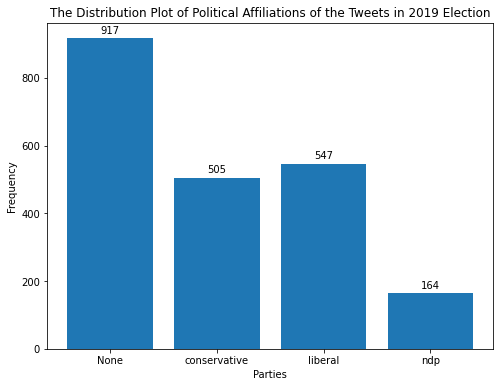

In [0]:
counter = df_elections.groupby('party')['party'].count()
plt.figure(figsize=(8,6))
plt.bar(counter.keys(),counter)
plt.title('The Distribution Plot of Political Affiliations of the Tweets in 2019 Election')
plt.xlabel('Parties')
plt.ylabel('Frequency')
ax = plt.gca()
ind = 0
for party in counter.keys():
  ax.annotate(str(counter[party]),
                      xy=(ind, counter[party]),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
  ind +=1
plt.show()

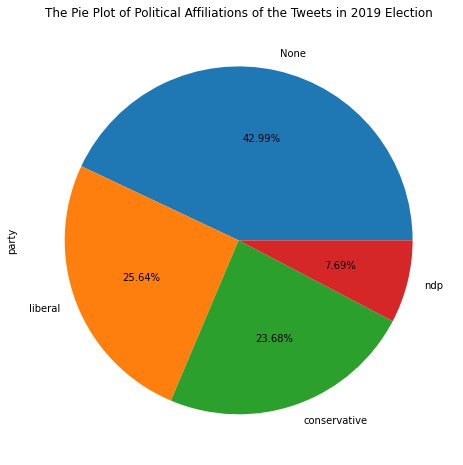

In [0]:
plt.figure(figsize=(8,8))
pd.Series(df_elections['party']).value_counts().plot(kind='pie', title='The Pie Plot of Political Affiliations of the Tweets in 2019 Election',autopct='%.2f%%')
plt.show()

**Conclusion:**
There are 917 (42.99%) tweets not related to the three major parties (some of them might refer to some minor party such as "Green Party of Canada" which is not classified here). Among the three major parties, "Liberal Party" is mentioned in 547 (25.64%) tweets while "Conservative Party" is slightly less popular than "Liberal Party" with 505 (23.68%) tweets. NDP is mentioned less than others, with 164 tweets (7.69%).

### 2.4 Visualize the Distribution of the Reason of Tweets been Negative

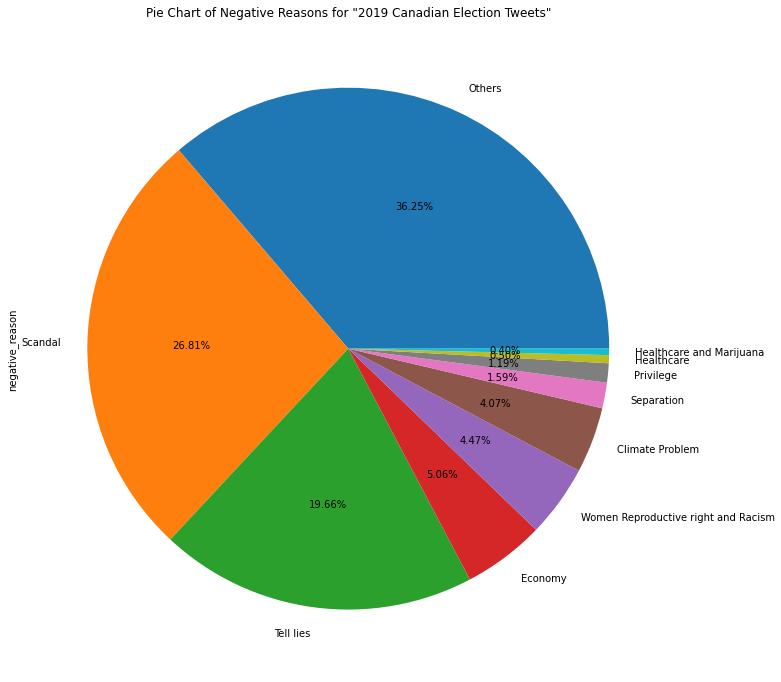

In [0]:
plt.figure(figsize=(12,12))
pd.Series(df_elections['negative_reason']).value_counts().plot(kind='pie', title='Pie Chart of Negative Reasons for "2019 Canadian Election Tweets"',autopct='%.2f%%')
plt.show()

**Conclusion:**
As shown in the pie chart, despite 36.25% reason from "others", the major reason for tweets been negative in 2019 Canadian election is "Scandal" which occupies 26.81% and "Tell Lies" which occupies 19.66%.

### 2.5 Visualization of Generic Tweets
Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that
visualizes some aspect of the generic tweets from Sentiment.csv file

In [0]:
generic_tweets_sentiment = df_sentiment.groupby('sentiment')['sentiment'].count()
election_tweets_sentiment = df_elections.groupby('sentiment')['sentiment'].count()
generic_tweets_negative = generic_tweets_sentiment['Negative']
generic_tweets_positive = generic_tweets_sentiment['Positive']
election_tweets_negative = election_tweets_sentiment['Negative']
election_tweets_positive = election_tweets_sentiment['Positive']
generic_tweets_positive_rate = generic_tweets_positive/(generic_tweets_negative+generic_tweets_positive)
generic_tweets_negative_rate = generic_tweets_negative/(generic_tweets_negative+generic_tweets_positive)
election_tweets_positive_rate = election_tweets_positive/(election_tweets_positive+election_tweets_negative)
election_tweets_negative_rate = election_tweets_negative/(election_tweets_positive+election_tweets_negative)

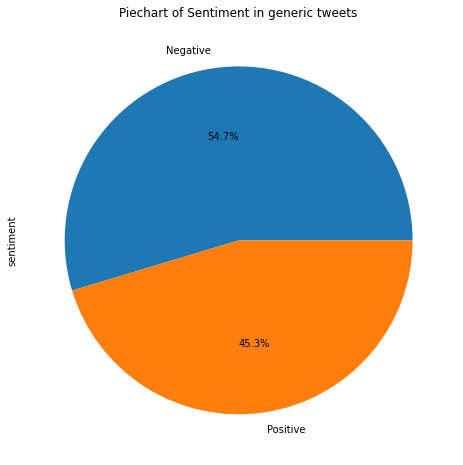

In [0]:
plt.figure(figsize=(8,8))
pd.Series(df_sentiment['sentiment']).value_counts().plot(autopct='%0.1f%%',kind='pie', title='Piechart of Sentiment in generic tweets')
plt.show()

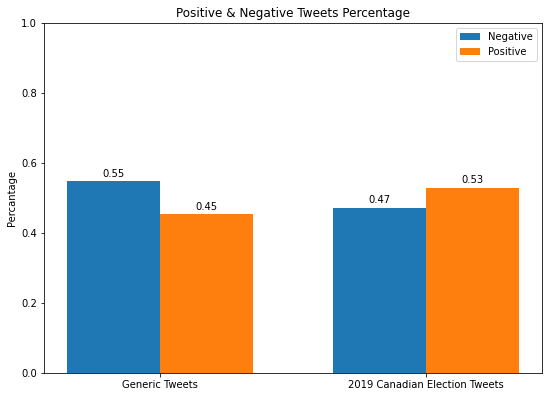

In [0]:
labels = ['Generic Tweets', '2019 Canadian Election Tweets']
generic_tweets = [generic_tweets_negative_rate, election_tweets_negative_rate]
election_tweets = [generic_tweets_positive_rate, election_tweets_positive_rate]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, generic_tweets, width, label='Negative')
rects2 = ax.bar(x1 + width/2, election_tweets, width, label='Positive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Positive & Negative Tweets Percentage')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(8,6)
plt.show()

**Conclusion:** From the bar chart, we can see that for Generic Tweets, there are about 45% tweets been positive and 55% tweets been Positive, while for the 2019 Canadian Election Tweets, there are 47% tweets been negative and 53% been positive.

### 2.5 **[Bonus]** Display most popular words used in  Positive & Negative Tweets with WordCloud

In this section, the most popular words used in Positive/Negative tweets are displayed using WordCloud, the bigger the words, the more oftenly the words used in this class

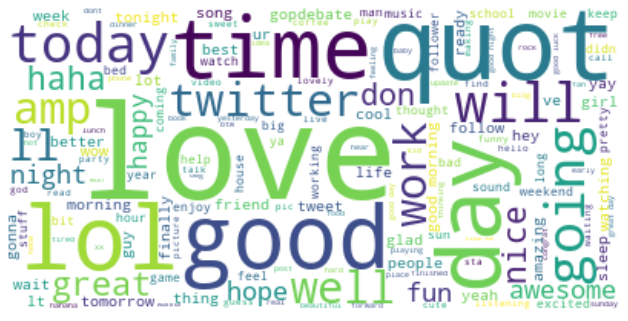

In [0]:
from wordcloud import WordCloud
plt.figure(figsize=(11, 9))
plt.axis("off")
positive_words = pd.Series(df_sentiment[df_sentiment['sentiment'] == "Positive"].cleaned_text.tolist()).str.cat(sep=' ')
wordcloud = WordCloud(stopwords=stop_words,background_color='white').generate(positive_words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

**Conculsion:** As can be seen from the Positive Tweets WordCloud, the words which are oftenly used are "Love", "LOL", "Good" which usually represent positive feelings.

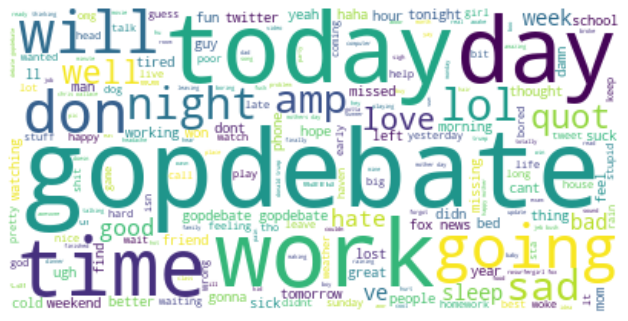

In [0]:
plt.figure(figsize=(11, 9))
plt.axis("off")
negative_words = pd.Series(df_sentiment[df_sentiment['sentiment'] == "Negative"].cleaned_text.tolist()).str.cat(sep=' ')
wordcloud = WordCloud(stopwords=stop_words,background_color='white').generate(negative_words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

**Conculsion:** From the negative word cloud, the words which are frequently used in Negative Tweets are "GopDebate", "Work", "Hate","bad", etc. Notice that "Gop debate" is frequently used here, it might suggests that people are not pleased with the speech in the party presidential debate.  

## 3.Model preparation (15 marks):
Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, word frequency (WF) and TF-IDF.

### 3.1 Prepocess Generic tweets for Model Training

#### 3.1.1 Extract the Feature Column and Target Column

In [0]:
#Drop irrelevant columns and only keep "cleaned_tweet" and encoded target "target"
df_sentiment_processed = df_sentiment[['cleaned_text','target']]
df_elections_processed = df_elections[['cleaned_text','target']]
df_sentiment_processed.head()

,cleaned_text,target
0,diplomtc immnty realdonaldtrump amp poll numbe...,1
1,chiefy74 damn jealous wanna watch fight love ufc,0
2,listening beatles great,1
3,ddlovato shout huge fan wait cd,1
4,salspizza spotted ur message tony replied,1


In [0]:
df_elections_processed.head()

,cleaned_text,target
0,rosiebarton suggestion agree canadian women tr...,0
1,allwomanspacewalk real space station etobicoke...,1
2,brantford going cost 94 billion 4 years justin...,0
3,canada canadaelection2019 canadavotes elxn43 n...,1
4,canada taxpayers sick amp tired hard earned do...,0


### 3.2 Model Preparation using Word Frequency (WF)

Word Frequency, aka Bag of Words (BoW) is an algorithm to count how many times a word appears in a sentence/docoment. In this section, I'm using the feature selection from WF

#### 3.2.1 Feature Selection Using Word Frequency (WF) (Bag of Words)



> To avoid RAM out of memory issue and reduce the calculation time cost, the selected max number of features are 10000



In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
#initialize the CountVectorizer
myCountVectorizer = CountVectorizer(analyzer='word',max_features=10000)
#Generate the Word Frequency Matrix
sentiment_word_frequency_matrix = myCountVectorizer.fit_transform(df_sentiment_processed["cleaned_text"])

The following code can display the Dataframe of the dataset after word frequency, while this takes too much memory and I decide to comment out them

In [0]:
# df_sentiment_wf = pd.DataFrame(sentiment_word_frequency_matrix.toarray())
# df_sentiment_wf.columns = features
# df_sentiment_wf.head()

#### 3.2.2 Split the Sentiment Dataset (with WF features) into 70% Train Set and 30% Test Set


In [0]:
from sklearn.model_selection import train_test_split
#All the features
X=sentiment_word_frequency_matrix
#All the targets
y=df_sentiment_processed['target']
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=rands)

#### 3.2.3 Implement Logistic Regression Model (with features of WF)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score

param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.01,0.05,0.1,0.5,1,5,10],
              'solver' : ['liblinear']}

#Linear regression model
lr = LogisticRegression()
#grid search engine
grdlr = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_lr = grdlr.fit(X_train, y_train)
#best parameter results for grid search
print("Best hyperparameter combination:\n",grdlr.best_params_)
print("Best score:\n",grdlr.best_score_)
start_time = time.time()
best_lr = LogisticRegression(penalty=grdlr.best_params_["penalty"],C=grdlr.best_params_["C"],solver=grdlr.best_params_["solver"])
best_lr.fit(X_train, y_train)
lr_y_train_pred = best_lr.predict(X_train)
lr_y_test_pred = best_lr.predict(X_test)
lr_train_acc = accuracy_score(y_train, lr_y_train_pred)
lr_test_acc = accuracy_score(y_test, lr_y_test_pred)

print("=================  Result    =========================")
lr_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using Logistic Regression =",lr_train_acc)
print("Test accuracy using Logistic regression =",lr_test_acc)
print("Time Cost=",lr_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,lr_y_test_pred))

Best hyperparameter combination:
 {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:
 0.7431716934081558
=================  Result    =========================
Train accuracy using Logistic Regression = 0.7892693914146384
Test accuracy using Logistic regression = 0.7413067326581116
Time Cost= 796.751 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     21354
           1       0.71      0.73      0.72     17843

    accuracy                           0.74     39197
   macro avg       0.74      0.74      0.74     39197
weighted avg       0.74      0.74      0.74     39197



#### 3.2.4 Impliment k-NN Model (with features of WF)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
#Init knn model here we set n_neigbors to be 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_train_pred = knn.predict(X_train)
knn_y_test_pred = knn.predict(X_test)
knn_train_acc = accuracy_score(y_train, knn_y_train_pred)
knn_test_acc = accuracy_score(y_test, knn_y_test_pred)

print("=================  Result    =========================")
knn_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using k-NN Mode (n=5) =",knn_train_acc)
print("Test accuracy using k-NN Mode (n=5) =",knn_test_acc)
print("Time Cost=",knn_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,knn_y_test_pred))


=================  Result    =========================
Train accuracy using k-NN Mode (n=5) = 0.764864746659669
Test accuracy using k-NN Mode (n=5) = 0.6580350537030896
Time Cost= 241784.716 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     21354
           1       0.61      0.68      0.64     17843

    accuracy                           0.66     39197
   macro avg       0.66      0.66      0.66     39197
weighted avg       0.66      0.66      0.66     39197



#### 3.2.5 Impliment Naive Bayes Model (with features of WF)

In [0]:
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")

param_grid = {'alpha' : [0,0.5,1,5,10,50,100]}

#Naive Bayes Model
nb = MultinomialNB()
#grid search engine
grdnb = GridSearchCV(estimator = nb, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_nb = grdnb.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdnb.best_params_)
print("Best score:\n",grdnb.best_score_)
start_time = time.time()
best_nb = MultinomialNB(alpha=grdnb.best_params_["alpha"])
best_nb.fit(X_train, y_train)
nb_y_train_pred = best_nb.predict(X_train)
nb_y_test_pred = best_nb.predict(X_test)
nb_train_acc = accuracy_score(y_train, nb_y_train_pred)
nb_test_acc = accuracy_score(y_test, nb_y_test_pred)

print("=================  Result    =========================")
nb_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Naive Bayes =",nb_train_acc)
print("Test accuracy using Naive Bayes =",nb_test_acc)
print("Time Cost=",nb_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,nb_y_test_pred))

Best hyperparameter combination:
 {'alpha': 5}
Best score:
 0.7345994918054802
=================  Result    =========================
Train accuracy using Naive Bayes = 0.7625139408252969
Test accuracy using Naive Bayes = 0.7350307421486338
Time Cost= 41.749 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     21354
           1       0.72      0.69      0.70     17843

    accuracy                           0.74     39197
   macro avg       0.73      0.73      0.73     39197
weighted avg       0.73      0.74      0.73     39197



#### 3.2.6 Impliment SVM Model (with features of WF)

In [0]:
from sklearn.svm import LinearSVC


param_grid = {'C' : [0.01,0.1,1]}

svm = LinearSVC()
#grid search engine
grdsvm = GridSearchCV(estimator = svm, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_svm = grdsvm.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdsvm.best_params_)
print("Best score:\n",grdsvm.best_score_)
start_time = time.time()
best_svm = LinearSVC(C=grdsvm.best_params_["C"])
best_svm.fit(X_train, y_train)
svm_y_train_pred = best_svm.predict(X_train)
svm_y_test_pred = best_svm.predict(X_test)
svm_train_acc = accuracy_score(y_train, svm_y_train_pred)
svm_test_acc = accuracy_score(y_test, svm_y_test_pred)

print("=================  Result    =========================")
svm_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using SVM Model =",svm_train_acc)
print("Test accuracy using SVM Model =",svm_test_acc)
print("Time Cost=",svm_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,svm_y_test_pred))

Best hyperparameter combination:
 {'C': 0.01}
Best score:
 0.7422204465378057
=================  Result    =========================
Train accuracy using SVM Model = 0.7724638631940344
Test accuracy using SVM Model = 0.7414342934408246
Time Cost= 444.906 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     21354
           1       0.71      0.72      0.72     17843

    accuracy                           0.74     39197
   macro avg       0.74      0.74      0.74     39197
weighted avg       0.74      0.74      0.74     39197



#### 3.2.7 Impliment Decision Trees Model (with features of WF)

The run time for Decision Tree is very long, thus the maximun depth of the tree is set to be 100

In [0]:
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
#Init Decison Tree model here
dt = DecisionTreeClassifier(max_depth=100)
dt.fit(X_train, y_train)
dt_y_train_pred = dt.predict(X_train)
dt_y_test_pred = dt.predict(X_test)
dt_train_acc = accuracy_score(y_train, dt_y_train_pred)
dt_test_acc = accuracy_score(y_test, dt_y_test_pred)

print("=================  Result    =========================")
dt_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using Decision Trees Model =",dt_train_acc)
print("Test accuracy using Decision Trees Model =",dt_test_acc)
print("Time Cost=",dt_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,dt_y_test_pred))

=================  Result    =========================
Train accuracy using Decision Trees Model = 0.7540838417634323
Test accuracy using Decision Trees Model = 0.6501262851748858
Time Cost= 9985.877 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.63      0.85      0.73     21354
           1       0.70      0.41      0.51     17843

    accuracy                           0.65     39197
   macro avg       0.67      0.63      0.62     39197
weighted avg       0.66      0.65      0.63     39197



#### 3.2.8 Impliment Random Forest Model (with features of WF)

The run time for Random Forest is very long, thus the maximun depth of the tree is set to be 100

In [0]:
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
#Init Random Forest model here
rf = RandomForestClassifier(max_depth=100)
rf.fit(X_train, y_train)
rf_y_train_pred = rf.predict(X_train)
rf_y_test_pred = rf.predict(X_test)
rf_train_acc = accuracy_score(y_train, rf_y_train_pred)
rf_test_acc = accuracy_score(y_test, rf_y_test_pred)

print("=================  Result    =========================")
rf_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Random Forest Model =",rf_train_acc)
print("Test accuracy using Random Forest Model =",rf_test_acc)
print("Time Cost=",rf_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,rf_y_test_pred))

=================  Result    =========================
Train accuracy using Random Forest Model = 0.7963108749371296
Test accuracy using Random Forest Model = 0.6977829935964487
Time Cost= 49256.199 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.68      0.85      0.75     21354
           1       0.74      0.52      0.61     17843

    accuracy                           0.70     39197
   macro avg       0.71      0.68      0.68     39197
weighted avg       0.71      0.70      0.69     39197



#### 3.2.9 Impliment XGBoost Model (with features of WF)

In [0]:
import xgboost as xgb
start_time = time.time()
#Init Gradient Boosting Classifier model here
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
xgb_y_train_pred = xgb.predict(X_train)
xgb_y_test_pred = xgb.predict(X_test)
xgb_train_acc = accuracy_score(y_train, xgb_y_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_y_test_pred)

print("=================  Result    =========================")
xgb_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Gradient Boosting Classifier Model =",xgb_train_acc)
print("Test accuracy using Gradient Boosting Classifier Model =",xgb_test_acc)
print("Time Cost=",xgb_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,xgb_y_test_pred))

=================  Result    =========================
Train accuracy using Gradient Boosting Classifier Model = 0.6421089461829473
Test accuracy using Gradient Boosting Classifier Model = 0.6367579151465673
Time Cost= 5203.269 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.61      0.90      0.73     21354
           1       0.73      0.32      0.45     17843

    accuracy                           0.64     39197
   macro avg       0.67      0.61      0.59     39197
weighted avg       0.67      0.64      0.60     39197



### 3.3 Model Preparation using Term Frequency–Inverse Document Frequency (TF-IDF)



> In term-frequency-inverse document frequency, wordcounts are replaced with a TF-IDF score across the hwole dataset. 



#### 3.3.1 Feature Selection Using Term Frequency–Inverse Document Frequency (TF-IDF)



> To avoid RAM out of memory issue and reduce the calculation time cost, the selected max number of features are 10000



In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#initialize the TfidfVectorizer
myTfidfVectorizer = TfidfVectorizer(analyzer='word', max_features = 10000, use_idf=True, smooth_idf=True, norm=None)
#Generate the TFIDF Matrix
sentiment_tfidf_matrix = myTfidfVectorizer.fit_transform(df_sentiment_processed["cleaned_text"])

#### 3.3.2 Split the Sentiment Dataset (with TF-IDF features) into 70% Train Set and 30% Test Set

In [0]:
#All the features
X=sentiment_tfidf_matrix
#All the targets
y=df_sentiment_processed['target']
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=rands)


#### 3.3.3 Implement Logistic Regression Model (with features of TF-IDF)

In [0]:
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.01,0.05,0.1,0.5,1,5,10],
              'solver' : ['liblinear']}

#Linear regression model
lr2 = LogisticRegression()
#grid search engine
grdlr2 = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_lr2 = grdlr2.fit(X_train, y_train)
#best parameter results for grid search
print("Best hyperparameter combination:\n",grdlr2.best_params_)
print("Best score:\n",grdlr2.best_score_)
start_time = time.time() 
best_lr2 = LogisticRegression(penalty=grdlr2.best_params_["penalty"],C=grdlr2.best_params_["C"],solver=grdlr2.best_params_["solver"])
best_lr2.fit(X_train, y_train)
lr2_y_train_pred = best_lr2.predict(X_train)
lr2_y_test_pred = best_lr2.predict(X_test)
lr2_train_acc = accuracy_score(y_train, lr2_y_train_pred)
lr2_test_acc = accuracy_score(y_test, lr2_y_test_pred)

print("=================  Result    =========================")

lr2_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Logistic Regression =",lr2_train_acc)
print("Test accuracy using Logistic regression =",lr2_test_acc)

print("Time Cost=",lr2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,lr2_y_test_pred))

Best hyperparameter combination:
 {'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:
 0.7414550649046767
=================  Result    =========================
Train accuracy using Logistic Regression = 0.7719171641627851
Test accuracy using Logistic regression = 0.7407964895272597
Time Cost= 246.791 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     21354
           1       0.70      0.74      0.72     17843

    accuracy                           0.74     39197
   macro avg       0.74      0.74      0.74     39197
weighted avg       0.74      0.74      0.74     39197



#### 3.3.4 Impliment k-NN Model (with features of TF-IDF)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time() 
#Init knn model here we set n_neigbors to be 5
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train, y_train)
knn2_y_train_pred = knn2.predict(X_train)
knn2_y_test_pred = knn2.predict(X_test)
knn2_train_acc = accuracy_score(y_train, knn2_y_train_pred)
knn2_test_acc = accuracy_score(y_test, knn2_y_test_pred)

print("=================  Result    =========================")
knn2_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using k-NN Mode (n=5) =",knn2_train_acc)
print("Test accuracy using k-NN Mode (n=5) =",knn2_test_acc)
print("Time Cost=",knn2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,knn2_y_test_pred))

=================  Result    =========================
Train accuracy using k-NN Mode (n=5) = 0.772048371930285
Test accuracy using k-NN Mode (n=5) = 0.6624996810980432
Time Cost= 240382.827 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.70      0.66      0.68     21354
           1       0.62      0.67      0.64     17843

    accuracy                           0.66     39197
   macro avg       0.66      0.66      0.66     39197
weighted avg       0.67      0.66      0.66     39197



#### 3.3.5 Impliment Naive Bayes Model (with features of TF-IDF)

In [0]:
param_grid = {'alpha' : [0,0.5,1,5,10,50,100]}

#Naive Bayes Model
nb = MultinomialNB()
#grid search engine
grdnb2 = GridSearchCV(estimator = nb, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_nb2 = grdnb2.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdnb2.best_params_)
print("Best score:\n",grdnb2.best_score_)

start_time = time.time() 
best_nb2 = MultinomialNB(alpha=grdnb2.best_params_['alpha'])
best_nb2.fit(X_train, y_train)
nb2_y_train_pred = best_nb2.predict(X_train)
nb2_y_test_pred = best_nb2.predict(X_test)
nb2_train_acc = accuracy_score(y_train, nb2_y_train_pred)
nb2_test_acc = accuracy_score(y_test, nb2_y_test_pred)

print("=================  Result    =========================")
nb2_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using Naive Bayes =",nb2_train_acc)
print("Test accuracy using Naive Bayes =",nb2_test_acc)

print("Time Cost=",nb2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,nb2_y_test_pred))

Best hyperparameter combination:
 {'alpha': 100}
Best score:
 0.7333530279362565
=================  Result    =========================
Train accuracy using Naive Bayes = 0.7629841019921713
Test accuracy using Naive Bayes = 0.7348011327397505
Time Cost= 69.712 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     21354
           1       0.71      0.71      0.71     17843

    accuracy                           0.73     39197
   macro avg       0.73      0.73      0.73     39197
weighted avg       0.73      0.73      0.73     39197



#### 3.3.6 Impliment SVM Model (with features of TF-IDF)

In [0]:
param_grid = {'C' : [0.01,0.1,1]}

svm = LinearSVC()
#grid search engine
grdsvm2 = GridSearchCV(estimator = svm, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_svm2 = grdsvm2.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdsvm2.best_params_)
print("Best score:\n",grdsvm2.best_score_)

start_time = time.time() 
best_svm2 = LinearSVC(C=grdsvm2.best_params_["C"])
best_svm2.fit(X_train, y_train)
svm2_y_train_pred = best_svm2.predict(X_train)
svm2_y_test_pred = best_svm2.predict(X_test)
svm2_train_acc = accuracy_score(y_train, svm2_y_train_pred)
svm2_test_acc = accuracy_score(y_test, svm2_y_test_pred)

print("=================  Result    =========================")
svm2_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using SVM Model =",svm2_train_acc)
print("Test accuracy using SVM Model =",svm2_test_acc)

print("Time Cost=",svm2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,svm2_y_test_pred))

Best hyperparameter combination:
 {'C': 0.01}
Best score:
 0.7286732054398206
=================  Result    =========================
Train accuracy using SVM Model = 0.7988475584421264
Test accuracy using SVM Model = 0.7309998214149042
Time Cost= 5431.985 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     21354
           1       0.70      0.72      0.71     17843

    accuracy                           0.73     39197
   macro avg       0.73      0.73      0.73     39197
weighted avg       0.73      0.73      0.73     39197



#### 3.3.7 Impliment Decision Trees Model (with features of TF-IDF)

In [0]:
start_time = time.time()
#Init Decison Tree model here
dt2 = DecisionTreeClassifier(max_depth=100)
dt2.fit(X_train, y_train)
dt2_y_train_pred = dt2.predict(X_train)
dt2_y_test_pred = dt2.predict(X_test)
dt2_train_acc = accuracy_score(y_train, dt2_y_train_pred)
dt2_test_acc = accuracy_score(y_test, dt2_y_test_pred)

print("=================  Result    =========================")
dt2_time = round((time.time() - start_time)*1000,3)
print("Train accuracy using Decision Trees Model =",dt2_train_acc)
print("Test accuracy using Decision Trees Model =",dt2_test_acc)
print("Time Cost=",dt2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,dt2_y_test_pred))

=================  Result    =========================
Train accuracy using Decision Trees Model = 0.7538870301121826
Test accuracy using Decision Trees Model = 0.649360920478608
Time Cost= 9936.844 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.63      0.85      0.73     21354
           1       0.70      0.41      0.51     17843

    accuracy                           0.65     39197
   macro avg       0.66      0.63      0.62     39197
weighted avg       0.66      0.65      0.63     39197



#### 3.3.8 Impliment Random Forest Model (with features of TF-IDF)

In [0]:
start_time = time.time()
#Init Random Forest model here
rf2 = RandomForestClassifier(max_depth=100)
rf2.fit(X_train, y_train)
rf2_y_train_pred = rf2.predict(X_train)
rf2_y_test_pred = rf2.predict(X_test)
rf2_train_acc = accuracy_score(y_train, rf2_y_train_pred)
rf2_test_acc = accuracy_score(y_test, rf2_y_test_pred)

print("=================  Result    =========================")
rf2_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Random Forest Model =",rf2_train_acc)
print("Test accuracy using Random Forest Model =",rf2_test_acc)
print("Time Cost=",rf2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,rf2_y_test_pred))

=================  Result    =========================
Train accuracy using Random Forest Model = 0.7952940147390059
Test accuracy using Random Forest Model = 0.697323774778682
Time Cost= 47673.667 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.68      0.85      0.75     21354
           1       0.74      0.52      0.61     17843

    accuracy                           0.70     39197
   macro avg       0.71      0.68      0.68     39197
weighted avg       0.71      0.70      0.69     39197



#### 3.3.9 Impliment XGBoost Model (with features of TF-IDF)

In [0]:
import xgboost as xgb
start_time = time.time()
#Init Gradient Boosting Classifier model here
xgb2 = xgb.XGBClassifier()
xgb2.fit(X_train, y_train)
xgb2_y_train_pred = xgb2.predict(X_train)
xgb2_y_test_pred = xgb2.predict(X_test)
xgb2_train_acc = accuracy_score(y_train, xgb2_y_train_pred)
xgb2_test_acc = accuracy_score(y_test, xgb2_y_test_pred)

print("=================  Result    =========================")
xgb2_time = round((time.time() - start_time)*1000,3)

print("Train accuracy using Gradient Boosting Classifier Model =",xgb2_train_acc)
print("Test accuracy using Gradient Boosting Classifier Model =",xgb2_test_acc)
print("Time Cost=",xgb2_time , "ms")

print("=================== Classification Performance Report =========================")
print(classification_report(y_test,xgb2_y_test_pred))

=================  Result    =========================
Train accuracy using Gradient Boosting Classifier Model = 0.6421089461829473
Test accuracy using Gradient Boosting Classifier Model = 0.6367579151465673
Time Cost= 5103.882 ms
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.61      0.90      0.73     21354
           1       0.73      0.32      0.45     17843

    accuracy                           0.64     39197
   macro avg       0.67      0.61      0.59     39197
weighted avg       0.67      0.64      0.60     39197





> So far, 14 models are prepared and trained with the sentiment dataset with 70%/30% train test split, they are


1.   Logistic Regression Model (with WF)
2.   k-NN Model (with WF)
3.   Naive Bayes Model (with WF)
4.   SVM Model (with WF)
5.   Decision Trees Model (with WF)
6.   Random Forest Model (with WF)
7.   XGBoost Model (with WF)
8.   Logistic Regression Model (with TF-IDF)
9.   k-NN Model (with TF-IDF)
10.   Naive Bayes Model (with TF-IDF)
11.   SVM Model (with TF-IDF)
12.   Decision Trees Model (with TF-IDF)
13.   Random Forest Model (with TF-IDF)
14.   XGBoost Model (with TF-IDF)






## 4.Model implementation (30 marks):
For data from Sentiment.csv file, train models on the training data, tune the hyperparameters (if necessary, with cross-validation) and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Split the negative 2019 Canadian elections tweets into training data (70%) and test
data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of
your predictions from the previous part. Choose three algorithms from classification
algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles
(Random Forest, XGBoost)), train multi-class classification models to predict the reason
for the negative tweets. There are 10 different negative reasons labelled in the dataset. Feel
free to combine similar reasons into fewer categories as long as you justify your reasoning.
You are free to define input features of your model using word frequency analysis or other
techniques. 

### 4.1 Model Evaluation


> Since the model training process is also performed during the model preparation stage, in this section, I'm just going to compare the performance between each model and select the best model from the validation test result



#### 4.1.1 Compare the Performance bwtween WF and TF-IDF

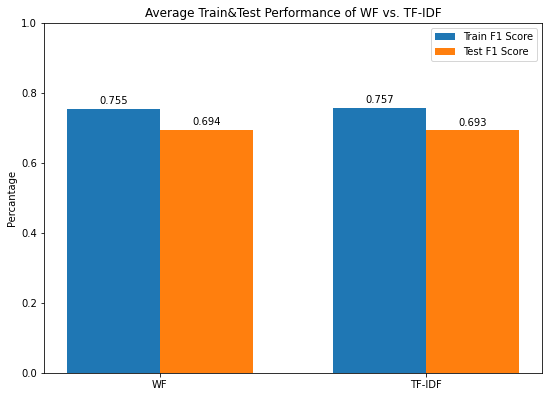

In [0]:
labels = ['WF', 'TF-IDF']
avg_train_results = [np.average([lr_train_acc, knn_train_acc,nb_train_acc,svm_train_acc,dt_train_acc,rf_train_acc,xgb_train_acc]),np.average([lr2_train_acc, knn2_train_acc,nb2_train_acc,svm2_train_acc,dt2_train_acc,rf2_train_acc,xgb2_train_acc])]
avg_test_results = [np.average([lr_test_acc, knn_test_acc,nb_test_acc,svm_test_acc,dt_test_acc,rf_test_acc,xgb_test_acc]),np.average([lr2_test_acc, knn2_test_acc,nb2_test_acc,svm2_test_acc,dt2_test_acc,rf2_test_acc,xgb2_test_acc])]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, avg_train_results, width, label='Train F1 Score')
rects2 = ax.bar(x1 + width/2, avg_test_results, width, label='Test F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Average Train&Test Performance of WF vs. TF-IDF')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(8,6)
plt.show()



> As shown in the diagram, WF and TF-IDF shows very similar performance while TF-IDF has a slightly better performance than WF.



#### 4.1.2 Compare the Performance between Different Models

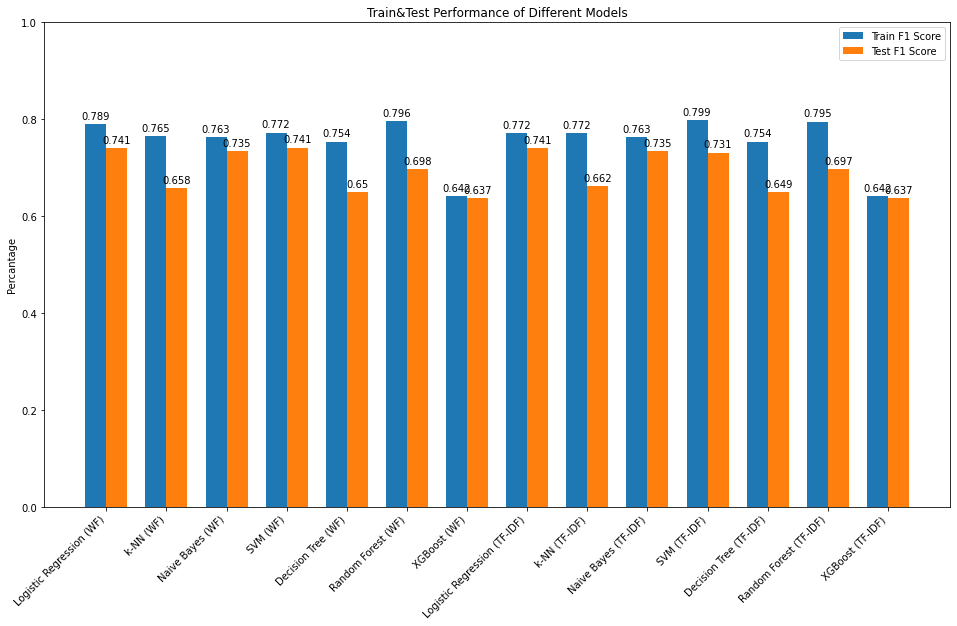

In [0]:
labels = ['Logistic Regression (WF)', 'k-NN (WF)', 'Naive Bayes (WF)', 'SVM (WF)','Decision Tree (WF)','Random Forest (WF)','XGBoost (WF)','Logistic Regression (TF-IDF)', 'k-NN (TF-IDF)', 'Naive Bayes (TF-IDF)', 'SVM (TF-IDF)','Decision Tree (TF-IDF)','Random Forest (TF-IDF)','XGBoost (TF-IDF)']
train_results = [lr_train_acc, knn_train_acc,nb_train_acc,svm_train_acc,dt_train_acc,rf_train_acc,xgb_train_acc,lr2_train_acc, knn2_train_acc,nb2_train_acc,svm2_train_acc,dt2_train_acc,rf2_train_acc,xgb2_train_acc]
test_results = [lr_test_acc, knn_test_acc,nb_test_acc,svm_test_acc,dt_test_acc,rf_test_acc,xgb_test_acc,lr2_test_acc, knn2_test_acc,nb2_test_acc,svm2_test_acc,dt2_test_acc,rf2_test_acc,xgb2_test_acc]


x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, train_results, width, label='Train F1 Score')
rects2 = ax.bar(x1 + width/2, test_results, width, label='Test F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Train&Test Performance of Different Models')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
plt.xticks(rotation=45, ha="right" )
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(16,14)
plt.show()

**Conclusion:**


>  By looking at the test accuracy, Logistic Regression model and SVM has best accuracy (over 74%), while k-NN, decision tree and XGBoost has relatively less accuracy (less than 65%). For now, we will consider using Logistic Regression model or SVM, further hyperparameter fine tuning can be performed later.



**[Bonus]**


> Hyperparameter tuning is used in this section for Logistic Regression, Naive Bayes and SVM to obtain the best parameters for each model



#### 4.1.2 **[BONUS] Comparison of the Time Cost of Training Different Models**


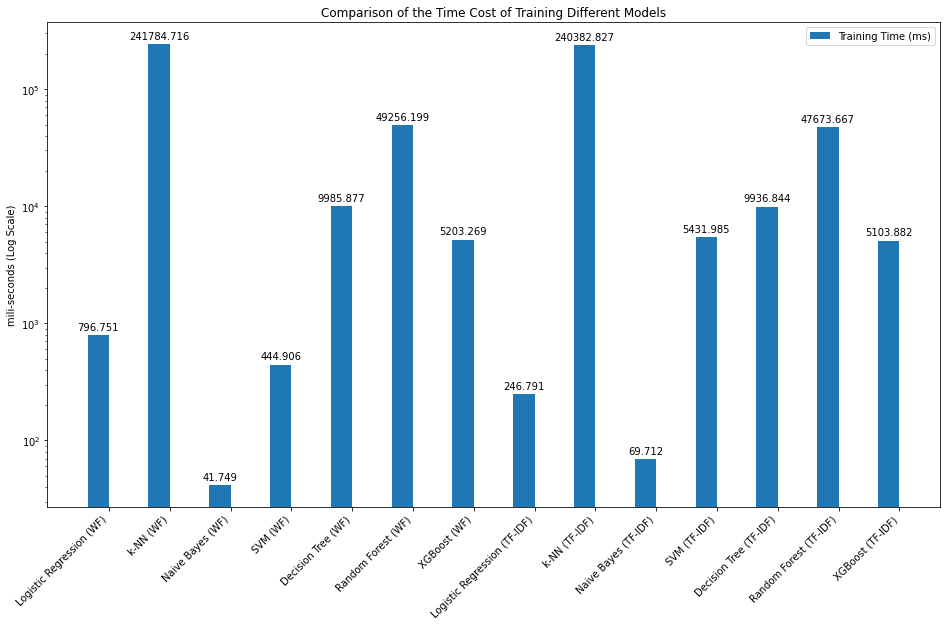

In [0]:
labels = ['Logistic Regression (WF)', 'k-NN (WF)', 'Naive Bayes (WF)', 'SVM (WF)','Decision Tree (WF)','Random Forest (WF)','XGBoost (WF)','Logistic Regression (TF-IDF)', 'k-NN (TF-IDF)', 'Naive Bayes (TF-IDF)', 'SVM (TF-IDF)','Decision Tree (TF-IDF)','Random Forest (TF-IDF)','XGBoost (TF-IDF)']
train_results = [lr_time, knn_time,nb_time,svm_time,dt_time,rf_time,xgb_time,lr2_time, knn2_time,nb2_time,svm2_time,dt2_time,rf2_time,xgb2_time]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, train_results, width, label='Training Time (ms)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mili-seconds (Log Scale)')
ax.set_title('Comparison of the Time Cost of Training Different Models')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
plt.xticks(rotation=45, ha="right" )
ax.set_yscale('log')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()
fig.set_size_inches(16,14)
plt.show()

[Bonus] (Comparison of the Time Cost of Training Different Models) Naive Bayes takes the least training time with about 43ms, and k-NN takes the longest time with 150000ms-190000ms.Time cost can be also considered as an aspect of selecting the optimal model, since Logistic Regression and SVM are considered to have best performance from previous section, however, considering the time cost, an interesting finding is that if using WF, the time cost of SVM is low while using TF-IDF, the time cost is actually very high. This might suggests that the value from TF-IDF causes slow convergence of SVM. 

### 4.2 Perform the prediction on 2019 Canadian election data with selected best model 

In [0]:
#Generate the TFIDF Matrix
elections_tfidf_matrix = myTfidfVectorizer.transform(df_elections_processed["cleaned_text"])

In [0]:
#All the features
X_elect=elections_tfidf_matrix
#All the targets
y_elect=df_elections_processed['target']

In [0]:
lr2_y_test_pred_election = best_lr2.predict(X_elect)
lr2_test_acc_election = accuracy_score(y_elect, lr2_y_test_pred_election)

print("=================  Result    =========================")
print("Test accuracy using Logistic regression =",lr2_test_acc_election)

print("=================== Classification Performance Report =========================")
print(classification_report(y_elect,lr2_y_test_pred_election))


=================  Result    =========================
Test accuracy using Logistic regression = 0.6179090482887951
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      1006
           1       0.65      0.61      0.63      1127

    accuracy                           0.62      2133
   macro avg       0.62      0.62      0.62      2133
weighted avg       0.62      0.62      0.62      2133



### 4.3 Compare the prediction with true value

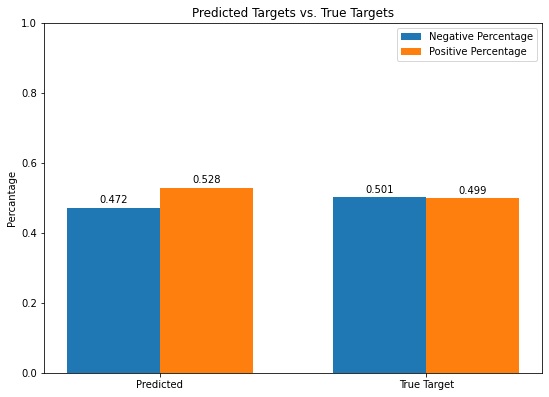

In [0]:
labels = ['Predicted', 'True Target']
election_neg = [1-np.sum(y_elect)/len(y_elect),1-np.sum(lr2_y_test_pred_election)/len(lr2_y_test_pred_election)]
election_true = [np.sum(y_elect)/len(y_elect),np.sum(lr2_y_test_pred_election)/len(lr2_y_test_pred_election)]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, election_neg, width, label='Negative Percentage')
rects2 = ax.bar(x1 + width/2, election_true, width, label='Positive Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Predicted Targets vs. True Targets')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(8,6)
plt.show()

The distribution of predicted target are very similar to the true target, which shows the model is not biased. In addition, the test accuracy reached over 60% which is not bad.

### 4.4 Visualize the Sentiment Prediction Results and the True Sentiment for each of the 3 Parties

In [0]:
df_elections['predicted']=lr2_y_test_pred_election.tolist()
df_election_results = df_elections[['party','negative_reason','target','predicted']]
df_election_results.head()

,party,negative_reason,target,predicted
0,conservative,Women Reproductive right and Racism,0,0
1,None,NaN,1,1
2,liberal,Economy,0,0
3,None,NaN,1,0
4,liberal,Economy,0,0


#### 4.4.1 Prediction Results for Liberal Party

In [0]:
df_liberal_results = df_election_results[df_election_results['party']=='liberal']
cm_lib = confusion_matrix(df_liberal_results['target'], df_liberal_results['predicted'])
cm_lib

array([[184, 107],
       [112, 144]])

In [0]:
print("=================== Classification Performance Report for  Liberal=========================")
print(classification_report(df_liberal_results['target'],df_liberal_results['predicted']))

=================== Classification Performance Report for  Liberal=========================
              precision    recall  f1-score   support

           0       0.62      0.63      0.63       291
           1       0.57      0.56      0.57       256

    accuracy                           0.60       547
   macro avg       0.60      0.60      0.60       547
weighted avg       0.60      0.60      0.60       547



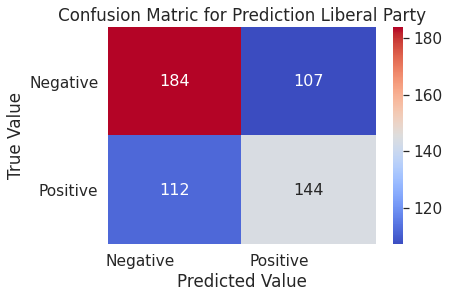

In [0]:
x_labels = ['Negative', 'Positive']
y_labels = ['Negative', 'Positive']
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_lib, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for Prediction Liberal Party')
heatmap.set_xticklabels(x_labels, rotation=0, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

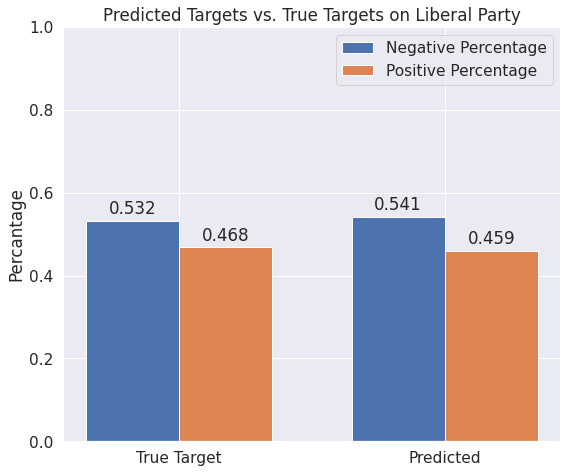

In [0]:
labels = ['True Target','Predicted']
election_neg_lib = [1-np.sum(df_liberal_results['target'])/len(df_liberal_results['target']),1-np.sum(df_liberal_results['predicted'])/len(df_liberal_results['predicted'])]
election_true_lib = [np.sum(df_liberal_results['target'])/len(df_liberal_results['target']),np.sum(df_liberal_results['predicted'])/len(df_liberal_results['predicted'])]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, election_neg_lib, width, label='Negative Percentage')
rects2 = ax.bar(x1 + width/2, election_true_lib, width, label='Positive Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Predicted Targets vs. True Targets on Liberal Party')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(10,8)
plt.show()

#### 4.4.2 Prediction Results for Conservative Party

In [0]:
df_conservative_results = df_election_results[df_election_results['party']=='conservative']
cm_cons = confusion_matrix(df_conservative_results['target'], df_conservative_results['predicted'])
cm_cons

array([[213, 128],
       [ 69,  95]])

In [0]:
print("=================== Classification Performance Report for Conservative=========================")
print(classification_report(df_conservative_results['target'],df_conservative_results['predicted']))

=================== Classification Performance Report for Conservative=========================
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       341
           1       0.43      0.58      0.49       164

    accuracy                           0.61       505
   macro avg       0.59      0.60      0.59       505
weighted avg       0.65      0.61      0.62       505



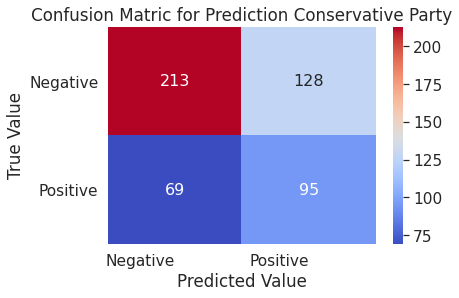

In [0]:
x_labels = ['Negative', 'Positive']
y_labels = ['Negative', 'Positive']
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_cons, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for Prediction Conservative Party')
heatmap.set_xticklabels(x_labels, rotation=0, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

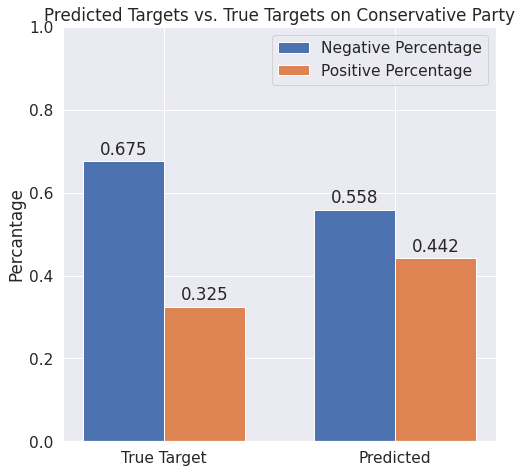

In [0]:
labels = ['True Target','Predicted']
election_neg_cons = [1-np.sum(df_conservative_results['target'])/len(df_conservative_results['target']),1-np.sum(df_conservative_results['predicted'])/len(df_conservative_results['predicted'])]
election_true_cons = [np.sum(df_conservative_results['target'])/len(df_conservative_results['target']),np.sum(df_conservative_results['predicted'])/len(df_conservative_results['predicted'])]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, election_neg_cons, width, label='Negative Percentage')
rects2 = ax.bar(x1 + width/2, election_true_cons, width, label='Positive Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Predicted Targets vs. True Targets on Conservative Party')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(10,8)
plt.show()

#### 4.4.3 Prediction Results for NDP

In [0]:
df_ndp_results = df_election_results[df_election_results['party']=='ndp']
cm_ndp = confusion_matrix(df_ndp_results['target'], df_ndp_results['predicted'])
cm_ndp

array([[29, 18],
       [38, 79]])

In [0]:
print("=================== Classification Performance Report for NDP=========================")
print(classification_report(df_ndp_results['target'],df_ndp_results['predicted']))

=================== Classification Performance Report for NDP=========================
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        47
           1       0.81      0.68      0.74       117

    accuracy                           0.66       164
   macro avg       0.62      0.65      0.62       164
weighted avg       0.71      0.66      0.67       164



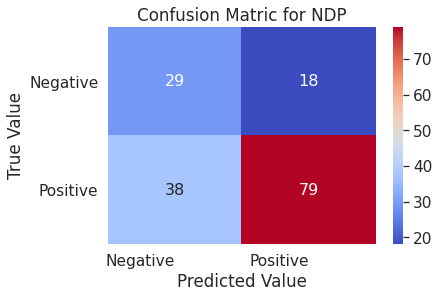

In [0]:
x_labels = ['Negative', 'Positive']
y_labels = ['Negative', 'Positive']
#plot
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_ndp, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for NDP')
heatmap.set_xticklabels(x_labels, rotation=0, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

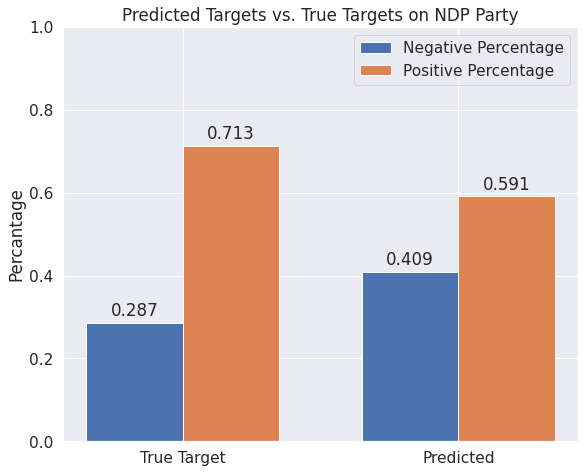

In [0]:
labels = ['True Target','Predicted']
election_neg_ndp = [1-np.sum(df_ndp_results['target'])/len(df_ndp_results['target']),1-np.sum(df_ndp_results['predicted'])/len(df_ndp_results['predicted'])]
election_true_ndp = [np.sum(df_ndp_results['target'])/len(df_ndp_results['target']),np.sum(df_ndp_results['predicted'])/len(df_ndp_results['predicted'])]

x1 = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


#Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()
rects1 = ax.bar(x1 - width/2, election_neg_ndp, width, label='Negative Percentage')
rects2 = ax.bar(x1 + width/2, election_true_ndp, width, label='Positive Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percantage')
ax.set_title('Predicted Targets vs. True Targets on NDP Party')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.set_ylim((0,1))
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(round(height,3),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(10,8)
plt.show()

**Discussion** 

* The bar charts show that the positive rate of tweets related to NDP is high, with 71.3% positive rate. While the positive rate for Conservative Party is very low, with only 32.5%. The positive rate for Liberal Party is moderate with 46.8%. 

* The barchart also shows that the distribution of the predicted value have less variance than the true distribution, which indicates the model might be underfitting and has high bias.

*   The prediction f1 score for Liberal party is 60%, for Conservative Party is 61% and for NDP is 66%. Which indicates the selected prediction model works well.

 

### 4.5 Analyze on Negative 2019 Canadian Election Tweets

#### 4.5.1 Prepare the data

In [0]:
df_election_neg_results = df_elections[df_elections['sentiment'] == 'Negative']
df_election_neg_results = df_election_neg_results[['negative_reason','cleaned_text']]
df_election_neg_results.head()

,negative_reason,cleaned_text
0,Women Reproductive right and Racism,rosiebarton suggestion agree canadian women tr...
2,Economy,brantford going cost 94 billion 4 years justin...
4,Economy,canada taxpayers sick amp tired hard earned do...
5,Others,canadavotes2019 elxn43 cdnpoli facts blastfrom...
8,Others,chooseforward cdnpoli elxn43 ncanada don ameri...


In [0]:
df_election_neg_results.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

#### 4.5.2 Feature Selection Using Term Frequency–Inverse Document Frequency (TF-IDF)



> To avoid RAM out of memory issue and reduce the calculation time cost, the selected max number of features are 10000

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#initialize the TfidfVectorizer
myTfidfVectorizer2 = TfidfVectorizer(analyzer='word', max_features = 10000, use_idf=True, smooth_idf=True, norm=None)
#Generate the TFIDF Matrix
election_neg_tfidf_matrix = myTfidfVectorizer2.fit_transform(df_election_neg_results["cleaned_text"])

In [0]:
def encoder(s):
  encode_dict = {
                  'Women Reproductive right and Racism':0, 
                  'Economy':1, 
                  'Others':2,
                  'Scandal':3, 
                  'Tell lies':4,
                  'Privilege':5, 
                  'Climate Problem':6,
                  'Healthcare':7, 
                  'Separation':8, 
                  'Healthcare and Marijuana':9  
                }
  return encode_dict[s]

df_election_neg_results['target'] = df_election_neg_results['negative_reason'].apply(lambda x: encoder(x))
df_election_neg_results.head()

,negative_reason,cleaned_text,target
0,Women Reproductive right and Racism,rosiebarton suggestion agree canadian women tr...,0
2,Economy,brantford going cost 94 billion 4 years justin...,1
4,Economy,canada taxpayers sick amp tired hard earned do...,1
5,Others,canadavotes2019 elxn43 cdnpoli facts blastfrom...,2
8,Others,chooseforward cdnpoli elxn43 ncanada don ameri...,2


In [0]:
X = election_neg_tfidf_matrix
y = df_election_neg_results['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rands)

#### 4.5.3 Implement Logistic Regression Model (with features of TF-IDF)


> [Bonus] with hyper parameter tuning



In [0]:
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.01,0.05,0.1,0.5,1,5,10],
              'solver' : ['liblinear']}

#Linear regression model
lr3 = LogisticRegression()
#grid search engine
grdlr3 = GridSearchCV(estimator = lr, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_lr3 = grdlr3.fit(X_train, y_train)
#best parameter results for grid search
print("Best hyperparameter combination:\n",grdlr3.best_params_)
print("Best score:\n",grdlr3.best_score_)

best_lr3 = LogisticRegression(penalty=grdlr3.best_params_["penalty"],C=grdlr3.best_params_["C"],solver=grdlr3.best_params_["solver"])
best_lr3.fit(X_train, y_train)
lr3_y_train_pred = best_lr3.predict(X_train)
lr3_y_test_pred = best_lr3.predict(X_test)
lr3_train_acc = accuracy_score(y_train, lr3_y_train_pred)
lr3_test_acc = accuracy_score(y_test, lr3_y_test_pred)

print("Train accuracy using Logistic Regression =",lr3_train_acc)
print("Test accuracy using Logistic regression =",lr3_test_acc)

Best hyperparameter combination:
 {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:
 0.5681458966565349
Train accuracy using Logistic Regression = 0.9985795454545454
Test accuracy using Logistic regression = 0.5463576158940397


In [0]:
cm_lib = confusion_matrix(y_test, lr3_y_test_pred)
cm_lib

array([[10,  0,  3,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  7,  2,  3,  0,  1,  0,  0,  0],
       [ 0,  0, 75, 24, 11,  0,  0,  0,  0,  0],
       [ 0,  0, 36, 43,  3,  0,  0,  0,  0,  0],
       [ 3,  1, 18,  8, 33,  0,  1,  0,  0,  0],
       [ 0,  1,  2,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  4,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0]])

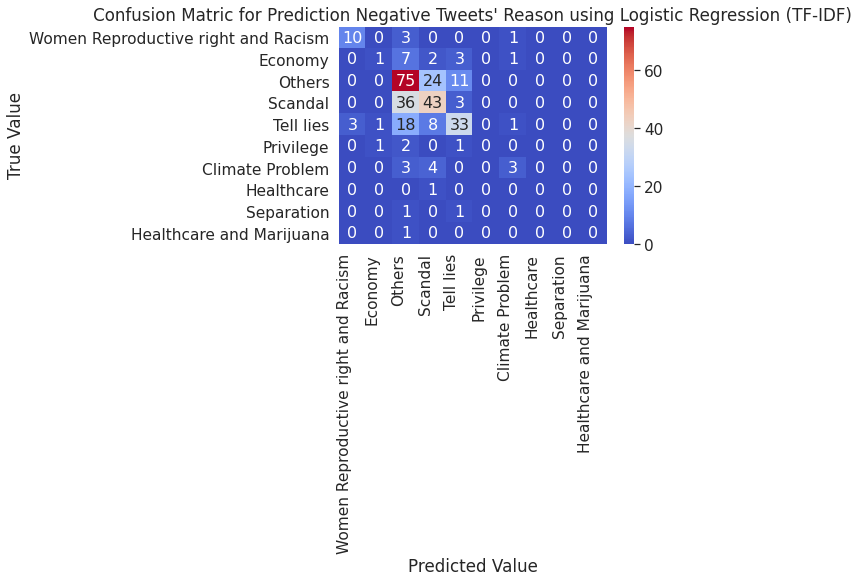

In [0]:
x_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
y_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_lib, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for Prediction Negative Tweets\' Reason using Logistic Regression (TF-IDF)')
heatmap.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

#### 4.5.4 Implement SVM Model (with features of TF-IDF)

In [0]:
param_grid = {'C' : [0.01,0.1,1]}

svm = LinearSVC()
#grid search engine
grdsvm3 = GridSearchCV(estimator = svm, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_svm3 = grdsvm3.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdsvm3.best_params_)
print("Best score:\n",grdsvm3.best_score_)

best_svm3 = LinearSVC(C=grdsvm3.best_params_["C"])
best_svm3.fit(X_train, y_train)
svm3_y_train_pred = best_svm3.predict(X_train)
svm3_y_test_pred = best_svm3.predict(X_test)
svm3_train_acc = accuracy_score(y_train, svm3_y_train_pred)
svm3_test_acc = accuracy_score(y_test, svm3_y_test_pred)

print("=================  Result    =========================")
print("Train accuracy using SVM Model =",svm3_train_acc)
print("Test accuracy using SVM Model =",svm3_test_acc)

Best hyperparameter combination:
 {'C': 0.01}
Best score:
 0.5496757852077001
=================  Result    =========================
Train accuracy using SVM Model = 0.9985795454545454
Test accuracy using SVM Model = 0.5397350993377483


In [0]:
cm_svm = confusion_matrix(y_test, svm3_y_test_pred)
cm_svm

array([[ 5,  0,  3,  4,  1,  0,  1,  0,  0,  0],
       [ 0,  4,  5,  2,  2,  0,  1,  0,  0,  0],
       [ 0,  1, 74, 24, 11,  0,  0,  0,  0,  0],
       [ 0,  0, 36, 40,  6,  0,  0,  0,  0,  0],
       [ 1,  0, 17,  8, 38,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  2,  2,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0]])

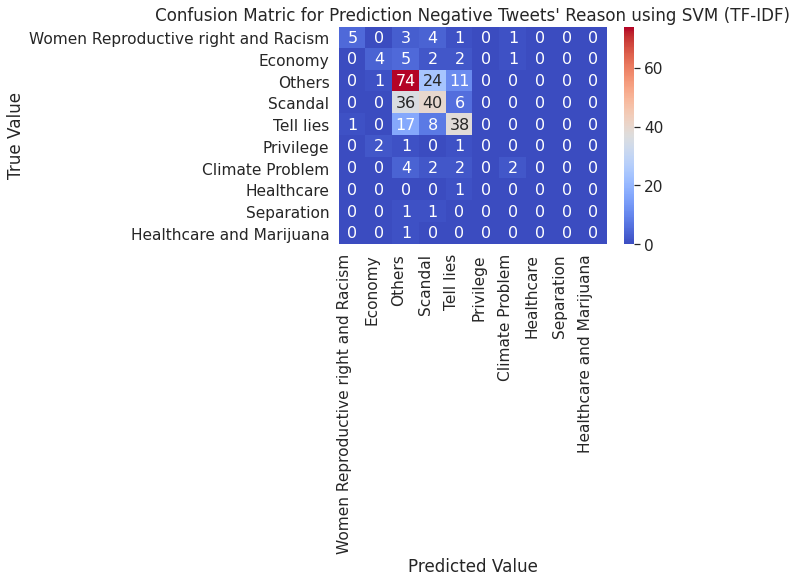

In [0]:
x_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
y_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_svm, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for Prediction Negative Tweets\' Reason using SVM (TF-IDF)')
heatmap.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

In [0]:
param_grid = {'alpha' : [0,0.5,1,5,10,50,100]}

#Naive Bayes Model
nb = MultinomialNB()
#grid search engine
grdnb3 = GridSearchCV(estimator = nb, param_grid = param_grid, scoring = 'accuracy')
#select best logisticregression model
best_nb3 = grdnb3.fit(X_train, y_train)

#best parameter results for grid search
print("Best hyperparameter combination:\n",grdnb3.best_params_)
print("Best score:\n",grdnb3.best_score_)

best_nb3 = MultinomialNB(alpha=grdnb3.best_params_['alpha'])
best_nb3.fit(X_train, y_train)
nb3_y_train_pred = best_nb3.predict(X_train)
nb3_y_test_pred = best_nb3.predict(X_test)
nb3_train_acc = accuracy_score(y_train, nb3_y_train_pred)
nb3_test_acc = accuracy_score(y_test, nb3_y_test_pred)

print("=================  Result    =========================")
print("Train accuracy using Naive Bayes =",nb3_train_acc)
print("Test accuracy using Naive Bayes =",nb3_test_acc)


Best hyperparameter combination:
 {'alpha': 5}
Best score:
 0.5
=================  Result    =========================
Train accuracy using Naive Bayes = 0.9829545454545454
Test accuracy using Naive Bayes = 0.44370860927152317


In [0]:
cm_nb = confusion_matrix(y_test, nb3_y_test_pred)
cm_nb

array([[ 7,  0,  2,  3,  1,  0,  1,  0,  0,  0],
       [ 0,  5,  3,  2,  2,  0,  2,  0,  0,  0],
       [ 8,  5, 39, 31, 23,  0,  2,  0,  2,  0],
       [ 2,  3, 19, 44,  6,  2,  3,  2,  1,  0],
       [ 4,  3,  9, 13, 34,  0,  1,  0,  0,  0],
       [ 0,  3,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  1,  1,  1,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0]])

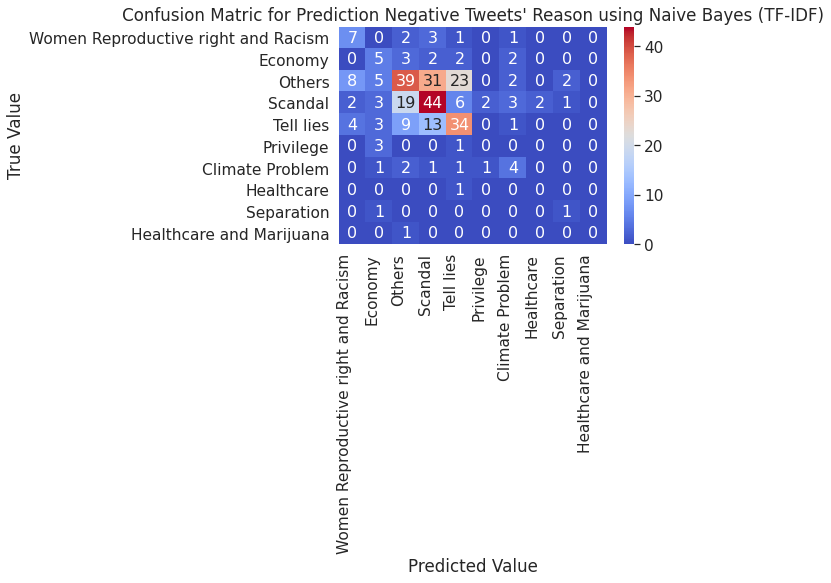

In [98]:
x_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
y_labels = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
heatmap = sns.heatmap(cm_nb, annot=True, annot_kws={"size": 16},fmt='g',cmap = 'coolwarm') # font size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matric for Prediction Negative Tweets\' Reason using Naive Bayes (TF-IDF)')
heatmap.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
heatmap.set_yticklabels(y_labels, rotation=0,horizontalalignment='right')
plt.show()

**Conclusion**


> There are 10 negative reasons and I encoded them from 0-9. I implemented three types of model (Logistic Regression, SVM, Naive Bayes) with TF-IDF feature selection method since these three model were tested to have the highest f1 score.



> The test accuracy for classify the reason of the negative tweets are: 54.6% for Logistic Regression, 54.0% for SVM and 44.4% for Naive Bayes. Notice that the expected accuracy for a random classifier for 10 class is 10%. So the trained model seems to be perform good. However, the given data is heavily inbalanced with majority of data entries in class of "other", "Scandal" and "Tell lies".





## 5.Results (20 marks):
Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. For both models, suggest one way you can improve the accuracy of your models.

### 5.1 Discussion on Model Selection



1.   **Logistic Regression**


> Logistic regression models the probability of a class using a logstic function. It is a linear model.


*   Pro: simple to impliment and its linear


*   Con: Dosen't wotk well with large feature space


---


2.   **k-NN Model**



> kMM model classifies a point based on its n nearlist neibours in the space

* Pro: No assumptions about the data
* Con Computationally expensive (this is shown in the previous record of time cost)

---


3.   **Naive Bayes**

> Predict model based on Bayes Theorem with probability hypothesis

* Pro: Fast and easy to impliment
* Con: Require the predictors to be independent

---

4.   **SVM**

>  SVM is a supervised machine learning model that determs binary class by placing an optimal margin to saperate the two class with support vectors

* Pro: Very effective in higer dimention, best ehrn classes are separable
* Con: For larger dataset it requires a large amount time to process

---

5.   **Decision Tree**

>  Decision Tree classifies model by building a flowchart-like structure and optimized by reducing the entropy of the subclass after spliting

* Pro: can work with numerical and categorical features

* Con: It always tends to overfit

---
6.   **Random Forest**

>  Random Forest classifier is based on decision tree but consists of a large number of individual decision trees that operate as an ensamble

* Pro: Good performance on many problems including non linear
* Con: No interpretability

7.   **XGBoost**

> XGBoost is an implementation of gradient boosted decision trees to perform classification

* Pro: a scalable and accurate implementation of gradient boosting machines
* Con: No interpretability




**After comparing pros and cons of the above models, I find Logistic Regression is the best for our project since it is good for binary classication and it is easy to impliment. SVM is also a good candidate but since our dataset is relatively large, using SVM requires large time cost. Thus Logistic Regression is relatively the best option and it is proved from previous sections that LR has best accuracy/F1 and less time cost**

### 5.2 Discussion on Feature Selection (WF(BoW) vs. TF-IDF)




> WF (BoW)


* Pros of WF (BoW): easy to impliment and requires less computation
* Cons of WF (BoW): Term ordering and rareness of a term is not considered




> TF-IDF

* Pros of TF-IDF: TF-IDF vectorizer gives an importance to the rarity of a word
* Cons of TF-IDF: Requires more computational cost


---




**In our case, the performance of TF-IDF is slightly better than WF**

### 5.3 Discussion on model prediction results



> The selected best model + feature selection is logistic regression + TF-IDF. The trained accuracy from sentiment dataset is 77.2% and test accuracy is 74%. When we perform classification of 2019 election dataset, the test accuracy is 62%. The discrepancy between the test accuracy from sentiment dataset and 2019 election dataset indicates that the features of sentiment dataset is similar to the features of 2019 election dataset. This might due to that some of the keywords which is essential for determing the target in sentiment dataset not work well in 2019 election dataset.  



### 5.4 Suggestion on Further Improvement

1.   **Perform finer hyperparameter tuning to select the best parameters for the Logistic Regression Model**
2.   **Might need to drop more irrelevant words other than the words on the stop words list**
3.   **Can add more keywords into the list to classifiying the political party of the tweets.**
4.   **The current approach of classification with by only looking at words in sentences is naive and we might need to consider using some other NLP techniques such as some techniques which can interprete the sementic meaning of the sentences**



## 6 [Bonus]

### 6.1 Bonus performed in the previous session


1.   2.5 Data visualization using word cloud
2.   L4.1.2 Compared the time cost of each model
3.   Performed hyperparameter tuning
4.   Display the results of the model visually using heat map to visulize the confusion matrix



#### 6.2 [Bonus]Try N-grams as feature engineering techniques in addition to WF and TF-IDF.

In [0]:
N_grams = (1, 10)
myTfidfVectorizer_ngrams = TfidfVectorizer(use_idf=False, norm="l1", ngram_range=N_grams)
sentiment_tfidf_matrix_ngram = myTfidfVectorizer_ngrams.fit_transform(df_sentiment_processed["cleaned_text"])
X=sentiment_tfidf_matrix_ngram
#All the targets
y=df_sentiment_processed['target']
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=rands)


In [102]:
#Generate the TFIDF Matrix
elections_tfidf_matrix_ngram = myTfidfVectorizer_ngrams.transform(df_elections_processed["cleaned_text"])
#All the features
X_elect_ngram=elections_tfidf_matrix_ngram
#All the targets
y_elect_ngram=df_elections_processed['target']
best_lr2.fit(X_train, y_train)
lr_y_test_pred_election_ngram = best_lr2.predict(X_elect_ngram)
lr_test_acc_election_ngram = accuracy_score(y_elect_ngram, lr_y_test_pred_election_ngram)

print("=================  Result    =========================")
print("Test accuracy using Logistic regression =",lr_test_acc_election_ngram)

print("=================== Classification Performance Report =========================")
print(classification_report(y_elect_ngram,lr_y_test_pred_election_ngram))


=================  Result    =========================
Test accuracy using Logistic regression = 0.4936708860759494
=================== Classification Performance Report =========================
              precision    recall  f1-score   support

           0       0.48      0.96      0.64      1006
           1       0.69      0.07      0.13      1127

    accuracy                           0.49      2133
   macro avg       0.59      0.52      0.39      2133
weighted avg       0.59      0.49      0.37      2133



**Discussion**
After implimenting the same model (Logistic Regression) with The performance from using the N_grams the test result reduced to 49% which is less than what we have before (62%). This suggests that the targets has more relationship to keywords instead the sequence of words.